#### Wave Equation $\partial^2_t\psi=c^2\partial^2_x\psi$ (Method of Lines)

In [50]:
function propogate(tspan::NTuple{2, Real}, xspan::NTuple{2, Real},
        dt::Real, dx::Real, x0::Real)
    (ti, tf), (xi, xf) = tspan, xspan
    t, x = ti:dt:tf, xi:dx:xf
    Nt, Nx = length(t), length(x)

    ψ = zeros(Nt, Nx, 2) # Numerical Solution
    
    # g(x) = abs(x - x0) <= 8 ? 0.5cos((π/16)*(x - x0))^4 : 0
    # h(x) = abs(x - x0) <= 8 ? 4*0.5*(π/16)*cos((π/16)*(x - x0))^3*sin((π/16)*(x - x0)) : 0
    
    g(x) = 0.5(exp(-(x - x0)^2/10))
    h(x) = 0.1(x0 - x) * g(x)
    
    ψ[1, :, :] = hcat(g.(x), h.(x))
    # ψ[1, :, :] = hcat(g.(x), zeros(Nx))
    
    # ψtt = ψxx | let ψ[1] = ψ, ψ[2] = ψt
    rhs(ψ, ψxx) = [ψ[2], ψxx]
    
    ψxx = 0; ψ1 = zeros(Nx, 2)
    ψIS, ψFS = Float64[], Float64[]
    k1, k2 = zeros(Nx, 2), zeros(Nx, 2)
    for i = 1:(Nt - 1) # Ralston's Method
        for j = 2:(Nx - 1)
            ψxx = (ψ[i, j + 1, 1] - 2ψ[i, j, 1] + ψ[i, j - 1, 1])/dx^2
            k1[j, :] = rhs(ψ[i, j, :], ψxx)
            ψ1[j, :] = ψ[i, j, :] + k1[j, :]*(3/4)*dt
        end
        for j = 2:(Nx - 1)
            ψxx = (ψ1[j + 1, 1] - 2ψ1[j, 1] + ψ1[j - 1, 1])/dx^2
            k2[j, :] = rhs(ψ1[j, :], ψxx)
            ψ[i + 1, j, :] = ψ[i, j, :] + dt*((1/3)*k1[j, :] + (2/3)*k2[j, :])
        end
    end

    return ψ, x
end;

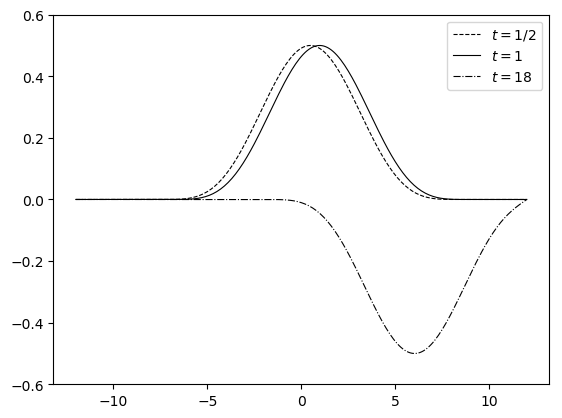

In [2]:
using PyPlot

dx = 0.1; dt = 0.25dx; n(t)::Int = ceil(t/dt)
ψrt, x = propogate((0, 20), (-12, 12), dt, dx, 0)
plot(x, ψrt[n(1/2), :, 1], "k--", linewidth=0.8, label=L"t=1/2")
plot(x, ψrt[n(1), :, 1], "k", linewidth=0.8, label=L"t=1")
plot(x, ψrt[n(18), :, 1], "k-.", linewidth=0.8, label=L"t=18")
plt.ylim(-0.6, 0.6); plt.legend();

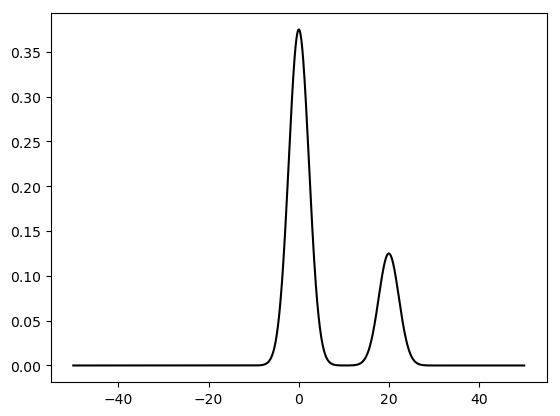

In [2]:
using PyPlot

dx, x0 = 0.1, 10; dt = 0.2dx
tspan, xspan = (0, 10), (-50, 50)
ψ, x = propogate(tspan, xspan, dt, dx, x0)
plot(x, ψ[500, :, 1], "k");

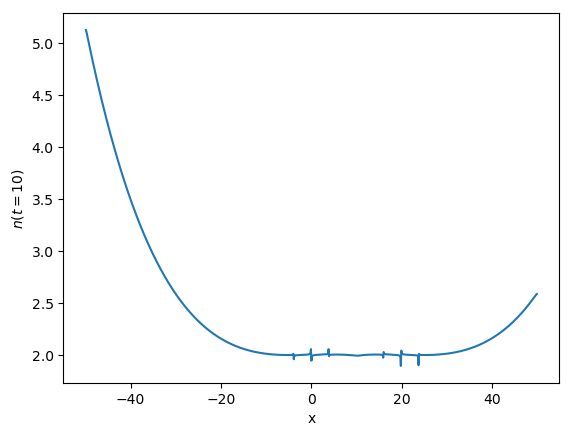

In [60]:
const VectorTuple = NTuple{N, Vector{<:Real}} where N

function convergence(ψ::VectorTuple{3})
    return log2.(abs.((ψ[1] - ψ[2])./(ψ[2] - ψ[3])))
end

function downsize(ψ0::Vector{<:Real}, N::Int=1)
        len = Int((size(ψ0)[1] - 1)/2) + 1
        ψ = zeros(len)
        for i = 1:len
            ψ[i] = ψ0[2i - 1]
        end  
    return N == 1 ? ψ : downsize(ψ, N - 1)
end

ψ1, x1 = propogate(tspan, xspan, dt/4, dx, x0)
ψ2, x2 = propogate(tspan, xspan, dt/4, dx/2, x0)
ψ3, x3 = propogate(tspan, xspan, dt/4, dx/4, x0)
ψ = (ψ1[end, :, 1], downsize(ψ2[end, :, 1]), downsize(ψ3[end, :, 1], 2))
plot(x1, convergence(ψ)); plt.xlabel("x"); plt.ylabel(L"n(t=10)");